# Project: Skin Lesion Analysis Towards Melanoma Detection

# Data preparation

In [1]:
import tensorflow as tf
print(tf.version.VERSION)


2.5.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from glob import glob
import seaborn as sns

from PIL import Image
np.random.seed(123)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

import shutil
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
from numpy.random import seed
seed(101)
tf.random.set_seed(101)

In [4]:
root_path = '/content/drive/MyDrive/ISIC'
train_path = '/content/drive/MyDrive/ISIC/ISIC_2019_Training_Input'

In [5]:
# Create a new directory for trainning data and validating data
base_dir = '/content/drive/MyDrive'
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
# val_dir
val_dir = os.path.join(base_dir, 'val_dir')

In [6]:
print(train_dir, '\n', val_dir)

/content/drive/MyDrive/train_dir 
 /content/drive/MyDrive/val_dir


In [7]:
if os.path.exists(train_dir) == False:
  os.mkdir(train_dir)
if os.path.exists(val_dir)==False:
  os.mkdir(val_dir)

# COMBINE THE GROUND TRUTH AND THE METADATA INCLUDING THE CHARACTERISTICS OF SUBJECTS

In [9]:
metadata_path = '/content/drive/MyDrive/ISIC/ISIC_2019_Training_Metadata.csv'
df_meta = pd.read_csv(metadata_path)
df_meta.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [10]:
gt_path = '/content/drive/MyDrive/ISIC/ISIC_2019_Training_GroundTruth.csv'
df_gt = pd.read_csv(gt_path)
df_gt.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_cell_type = pd.DataFrame([x for x in np.where(df_gt == 1, df_gt.columns,'').flatten().tolist() if len(x) > 0], columns= (["dx"]))
df_cell_type.head()


,dx
0,NV
1,NV
2,MEL
3,NV
4,MEL


In [12]:
df = pd.concat([df_meta, df_cell_type], axis=1, join='inner')
df.head()

,image,age_approx,anatom_site_general,lesion_id,sex,dx
0,ISIC_0000000,55.0,anterior torso,NaN,female,NV
1,ISIC_0000001,30.0,anterior torso,NaN,female,NV
2,ISIC_0000002,60.0,upper extremity,NaN,female,MEL
3,ISIC_0000003,30.0,upper extremity,NaN,male,NV
4,ISIC_0000004,80.0,posterior torso,NaN,male,MEL


In [13]:
df.isnull().sum()


image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dx                        0
dtype: int64

In [14]:
df['age_approx'].fillna((df['age_approx'].mean()), inplace=True)


In [15]:
df.dropna(subset=['anatom_site_general', 'lesion_id', 'sex'], inplace=True)
df.isnull().sum()

image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dx                     0
dtype: int64

In [16]:
df['image'].head()


1459    ISIC_0012653_downsampled
1460    ISIC_0012654_downsampled
1461    ISIC_0012655_downsampled
1462    ISIC_0012656_downsampled
1463    ISIC_0012657_downsampled
Name: image, dtype: object

In [17]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(root_path, '*', '*.jpg'))}

lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis-like lesions ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC': 'Squamous cell carcinoma',
    'UNK': 'None of the others'
}

# Creating New Columns for better readability

df['path'] = df['image'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.tail()

,image,age_approx,anatom_site_general,lesion_id,sex,dx,path,cell_type,cell_type_idx
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,None,Basal cell carcinoma,1
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,None,Benign keratosis-like lesions,2
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,None,Melanoma,5
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,None,Melanocytic nevi,4
25330,ISIC_0073254,50.0,upper extremity,BCN_0001079,male,BKL,None,Benign keratosis-like lesions,2


# Imbalanced data

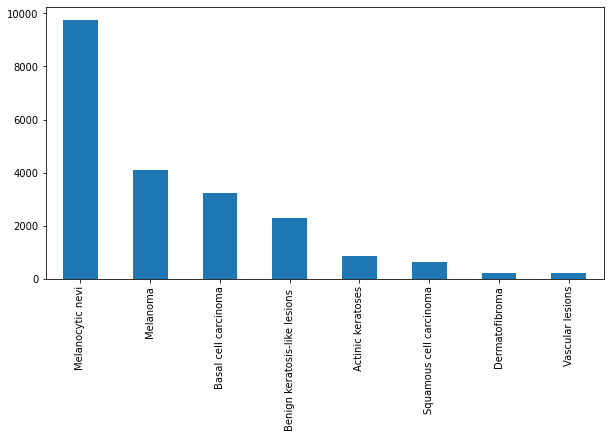

In [18]:
# Distribution of 9 classes
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [19]:
# this will tell us how many images are associated with each lesion_id
df_ = df.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df_ = df_[df_['image'] == 1]

df_.reset_index(inplace=True)

df_.head()

,lesion_id,image,age_approx,anatom_site_general,sex,dx,path,cell_type,cell_type_idx
0,BCN_0000013,1,1,1,1,1,0,1,1
1,BCN_0000020,1,1,1,1,1,0,1,1
2,BCN_0000039,1,1,1,1,1,0,1,1
3,BCN_0000053,1,1,1,1,1,0,1,1
4,BCN_0000059,1,1,1,1,1,0,1,1


In [20]:
# Identify lesion_id's that have duplicate images 

def identify_duplicates(x):
    
    unique_list = list(df_['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df['duplicates'] = df['lesion_id']
# apply the function to this new column
df['duplicates'] = df['duplicates'].apply(identify_duplicates)

df.tail()

,image,age_approx,anatom_site_general,lesion_id,sex,dx,path,cell_type,cell_type_idx,duplicates
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,None,Basal cell carcinoma,1,has_duplicates
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,None,Benign keratosis-like lesions,2,has_duplicates
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,None,Melanoma,5,has_duplicates
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,None,Melanocytic nevi,4,has_duplicates
25330,ISIC_0073254,50.0,upper extremity,BCN_0001079,male,BKL,None,Benign keratosis-like lesions,2,has_duplicates


# Duplicated data

In [21]:
#Count the number of duplicated images
df['duplicates'].value_counts()


has_duplicates    15959
no_duplicates      5357
Name: duplicates, dtype: int64

In [22]:
# now we filter out images that don't have duplicates
df_ = df[df['duplicates'] == 'no_duplicates']

df_.shape

(5357, 10)

In [23]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df_['dx']

_, df_val = train_test_split(df_, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(911, 10)

In [24]:
df_val['dx'].value_counts()


NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: dx, dtype: int64

In [25]:
# Create df_data excluding all rows that are in the val set

#  Identifies whether an image is part of the train or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df['train_or_val'] = df['image']
# apply the function to this new column
df['train_or_val'] = df['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df[df['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))


20405
911


In [26]:
# Check training data
df_train['dx'].value_counts()


NV      9128
MEL     4027
BCC     3185
BKL     2188
AK       831
SCC      604
DF       228
VASC     214
Name: dx, dtype: int64

In [27]:
# Check validating data

df_val['dx'].value_counts()


NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: dx, dtype: int64

In [28]:
# Set the image as the index in df_data
df.set_index('image', inplace=True)

**making data folder**

In [ ]:
# Get a list of images in the training folder
folder = os.listdir(train_path)
print(len(folder))
# Get a list of train and val images
train_list = list(df_train['image'])
val_list = list(df_val['image'])


# Transfer the train images
print(len(train_list), len(val_list))
for image in train_list:
    
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    
    if fname in folder:
        # source path to image
        src = os.path.join(train_path, fname)
        #print(os.path.exists(src), '*'*10)
        # destination path to image
        train_dir_01 = os.path.join(train_dir, label)
        if os.path.exists(train_dir_01)==False:
           os.mkdir(train_dir_01)
        dst = os.path.join(train_dir_01, fname)
        #print(os.path.exists(dst), '---', dst)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    
    if fname in folder:
      print(fname, '* '*30)
        # source path to image
        src = os.path.join(train_path, fname)
        # destination path to image
        val_dir_01 = os.path.join(val_dir, label)
        if os.path.exists(val_dir_01)==False:
           os.mkdir(val_dir_01)
        dst = os.path.join(val_dir_01, fname)
        #print(os.path.exists(dst), '*'*10, dst, '------------------')
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [29]:
# List the number of image in each training folder (8 subcategories)

print(len(os.listdir('/content/drive/MyDrive/train_dir/NV')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/MEL')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/BKL')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/BCC')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/AK')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/VASC')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/DF')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/SCC')))


9122
5330
5341
5360
5366
5370
5381
5526


In [30]:
# List the number of images in each validating folder (8 subcategories)

print(len(os.listdir('/content/drive/MyDrive/val_dir/NV')))
print(len(os.listdir('/content/drive/MyDrive/val_dir/MEL')))
print(len(os.listdir('/content/drive/MyDrive/val_dir/BKL')))
print(len(os.listdir('/content/drive/MyDrive/val_dir/BCC')))
print(len(os.listdir('/content/drive/MyDrive/val_dir/AK')))
print(len(os.listdir('/content/drive/MyDrive/val_dir/VASC')))
print(len(os.listdir('/content/drive/MyDrive/val_dir/DF')))
print(len(os.listdir('/content/drive/MyDrive/val_dir/SCC')))

623
74
107
60
14
8
7
18


In [ ]:
# Copy the train images into aug_dir
# note that we are not augmenting class 'nv'
class_list = ['MEL', 'BKL', 'BCC', 'AK', 'VASC', 'DF', 'SCC']

for item in class_list:
    
    # Creating temporary directories here because we delete these directories later
    # create a aug dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the aug dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 9200 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 9200 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

# Build model

In [31]:
# Set Up the Generators
train_path = '/content/drive/MyDrive/train_dir'
valid_path = '/content/drive/MyDrive/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)

train_batch_size = 20
val_batch_size = 20

# image_size = 224
image_size = 299

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [32]:
datagen = ImageDataGenerator(
    preprocessing_function= 
    tf.keras.applications.xception.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 47043 images belonging to 9 classes.
Found 911 images belonging to 8 classes.
Found 911 images belonging to 8 classes.


# Pretrained model: Xception 

In [33]:
# create a copy of a Xception model
Xception = tf.keras.applications.xception.Xception()

91889664/91884032 [==============================] - 1s 0us/step


In [34]:
Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [35]:
type(Xception.layers)


list

In [36]:
# The number of layers does Xception have
len(Xception.layers)

134

In [37]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = Xception.layers[-2].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = tf.keras.layers.Dropout(0.25)(x)
predictions = tf.keras.layers.Dense(9, activation='softmax')(x)

# inputs=Xception.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

Xception = tf.keras.Model(inputs=Xception.input, outputs=predictions)

In [38]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [39]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-134]:
    layer.trainable = False

In [40]:
# Define Top2 and Top3 Accuracy

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [41]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [42]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


In [43]:
# Add weights to try to make the model more sensitive to melanoma

class_weights = {
    0: 1.0,  # AK
    1: 1.0,  # BCC
    2: 1.0,  # BKL
    3: 1.0,  # DF
    4: 3.0,  # MEL # Try to make the model more sensitive to Melanoma.
    5: 1.0,  # NV
    6: 1.0,  # SCC
    7: 1.0,  # UNK
    8: 1.0,  # VASC
}

# Fit model

In [ ]:
filepath = "xception-134-trial03.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
 681/1021 [===================>..........] - ETA: 42:48 - loss: 2.6438 - categorical_accuracy: 0.1224 - top_2_accuracy: 0.3169 - top_3_accuracy: 0.4302